In [12]:
# Utilities
from pathlib import Path
import os, sys
import subprocess as sp

# Data
import pandas as pd
import numpy as np

# Brain
import nibabel as nb
from nibabel.freesurfer.io import read_annot, read_label, read_morph_data, read_geometry
import cortex
import src.mesh_laplace_sulci

import gdist
import pygeodesic.geodesic as geodesic

# Plotting
from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt

from utility_funcs import mris_convert_command

# Meshes
import igl
import meshplot 

from surface_funcs import * 




## Desired functions

1. Get ROI: using four boundary sulci, get all faces and vertices within them  
2. Get centroid: find the centroid of a label
3. Get crowns: find the gyral crowns (or pits) within a label
4. Autosegment: surface simplification for data-driven segmentation of labels
5. Geodesic distance: geodesic distance AND path between sets of vertices

Idea for 1:
- Get boundary vertices  
- draw geodesic path among boundary vertices  
- Geodesic path among edges i.e. superior edge of anterior -> anterior edge of superior  
- being at superior of anterior, move one edge posterior and inferior  
- if target vertex is not in boundary vertices, add face to label  
- if target vertex is in boundary vertices, select other edge ~~ which edge? spiral through  
  - before adding check all three adjacent triangles  
  - plan to go to next triangle which has border with added vertex  

In [13]:
# filepath = '/Users/benparker/Desktop/cnl/subjects/100307/surf/lh.pial'

# mris_convert_command(filepath, custom_filename='mris_convert')

In [14]:
subjects_dir = '/Users/benparker/Desktop/cnl/subjects'
labels = ['POS','MCGS']
sub = '100307'
hemi = 'lh'
outdir = '/Users/benparker/Desktop/cnl/CNL_scalpel/results'

#getDistMatrix(subjects_dir,labels,sub,hemi,outdir, fmri_prep=False)

In [15]:
highres_surface = f'{subjects_dir}/{sub}/surf/{hemi}.pial'
    
 
giidata = nb.freesurfer.read_geometry(highres_surface)
points, faces = giidata[0], giidata[1]

label_ind = nb.freesurfer.read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.MCGS.label')
label_points = points[label_ind]
label_faces = faces[label_ind]


In [16]:
unique_entry, count = np.unique(label_faces, return_counts=True)


In [18]:
adjacency = mesh_to_adjacency(faces, points)
adacent_nodes = adjacenct_nodes(adjacency, 0)

    

    

In [24]:
label_faces

array([[18428, 18445, 18444],
       [18432, 19482, 19481],
       [18968, 19961, 18993],
       ...,
       [63529, 63555, 63556],
       [63529, 64890, 64889],
       [63531, 63532, 64893]], dtype=int32)

In [28]:
## in theory this should work, but I'm not sure that I'm indexing the label correctly. Plotting this can clarify
def find_boundary_nodes(all_faces : np.ndarray, label_ind : np.ndarray):
    """ 
    Find the boundary faces of a label by isolating faces who include a node that onle appears in one face.
    
    INPUT:
    all_faces : np.array - an array of all the faces in the mesh
    label_ind : np.array - an array of the indices of the label

    OUTPUT:
    boundary_faces : np.array - an array of the boundary faces

    """
    # Get the unique nodes in the label
    unique_entry, count = np.unique(all_faces[label_ind], return_counts=True)
    # Get the nodes that only appear once
    boundary_nodes = unique_entry[count == 1]
    # Get the faces that include the boundary nodes
    boundary_faces = np.where(np.isin(all_faces, boundary_nodes))[0]
    # Remove duplicates
    boundary_faces = np.unique(boundary_faces)
    return boundary_nodes

    

In [21]:
test_sub = ScalpelSurface(subject_filepath='~/Desktop/cnl/subjects/100307')
boundary_dict = test_sub.get_boundary(anterior_label='MCGS', posterior_label='POS', 
                                      inferior_label='2', superior_label='MCGS', hemi='lh')


        
        

In [68]:
post_nodes = boundary_dict['posterior'][0]
post_nodes

post_points = boundary_dict['posterior'][1]
post_points[:15]


array([[-30.882, -15.272, -12.153],
       [-31.056, -14.723, -12.372],
       [-31.74 , -14.374, -12.744],
       [-35.542, -14.747, -14.27 ],
       [-35.638, -15.638, -13.796],
       [-35.245, -15.929, -13.284],
       [-31.741, -13.191, -12.971],
       [-34.278, -15.03 , -13.007],
       [-33.939, -14.71 , -12.71 ],
       [-33.263, -14.3  , -12.29 ],
       [-31.921, -13.233, -12.17 ],
       [-35.316, -17.303, -11.992],
       [-33.505, -14.712, -11.892],
       [-33.765, -15.352, -11.609],
       [-32.029, -13.687, -11.29 ]])

In [71]:
np.isin(np.round(np.take(points, post_nodes, axis=0), decimals=3), [-30.882, -15.272, -12.153]).sum()

0

In [17]:
label_annot = nb.freesurfer.read_annot('/Users/benparker/Desktop/cnl/subjects/100307/label/lh.PFC_annot.annot')

for id in np.unique(label_annot[0]):
    print('id = %d, sum = %d'%(id, (label_annot[0] == id).sum()))

id = -1, sum = 118706
id = 0, sum = 3643
id = 1, sum = 1131
id = 2, sum = 831
id = 3, sum = 832
id = 4, sum = 1639
id = 5, sum = 772
id = 6, sum = 397
id = 7, sum = 535
id = 8, sum = 1444
id = 9, sum = 698
id = 10, sum = 251


## GDist

In [16]:


geoalg = geodesic.PyGeodesicAlgorithmExact(points, faces)
sourceIndex = 25
targetIndex = 97
# Compute the geodesic distance and the path
distance, path = geoalg.geodesicDistance(sourceIndex, targetIndex)
path

array([[ -1.35481012, -76.9079895 , -11.9917984 ],
       [ -1.8057055 , -77.16084878, -12.15658785],
       [ -2.42826358, -77.44982389, -12.38781169],
       [ -2.59597011, -77.52264554, -12.45038318],
       [ -2.73134925, -77.57722628, -12.50106535],
       [ -3.34306614, -77.79669552, -12.7320138 ],
       [ -3.7647475 , -77.88611146, -12.89647065],
       [ -4.05438525, -77.93750909, -13.01024463],
       [ -4.35890905, -77.98404561, -13.13057137],
       [ -4.76563425, -78.02666812, -13.29281327],
       [ -5.27875079, -78.0546205 , -13.49930141],
       [ -5.5109015 , -78.05079138, -13.59323869],
       [ -5.65983488, -78.07304257, -13.65324915],
       [ -6.43935061, -78.11183167, -13.97138786]])

## Find boundary

In [26]:
## Load labels for boundary sulci


vertices, coords = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')
label_MCGS = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')

r_data = np.array([ras[0] for ras in coords])
a_data = np.array([ras[1] for ras in coords])
s_data = np.array([ras[2] for ras in coords])




In [32]:
test_vert_num, test_verts = find_boundary_vertices(boundary='anterior', read_label=label_MCGS, outlier_corrected=True, decimal_size=1)

test_r_data_min_inferior = np.array([ras[0] for ras in test_verts])
test_a_data_min_inferior = np.array([ras[1] for ras in test_verts])
test_s_data_min_inferior = np.array([ras[2] for ras in test_verts])



Text(0.5, 0.98, 'all vertices of MCGS vs anterior boundary')

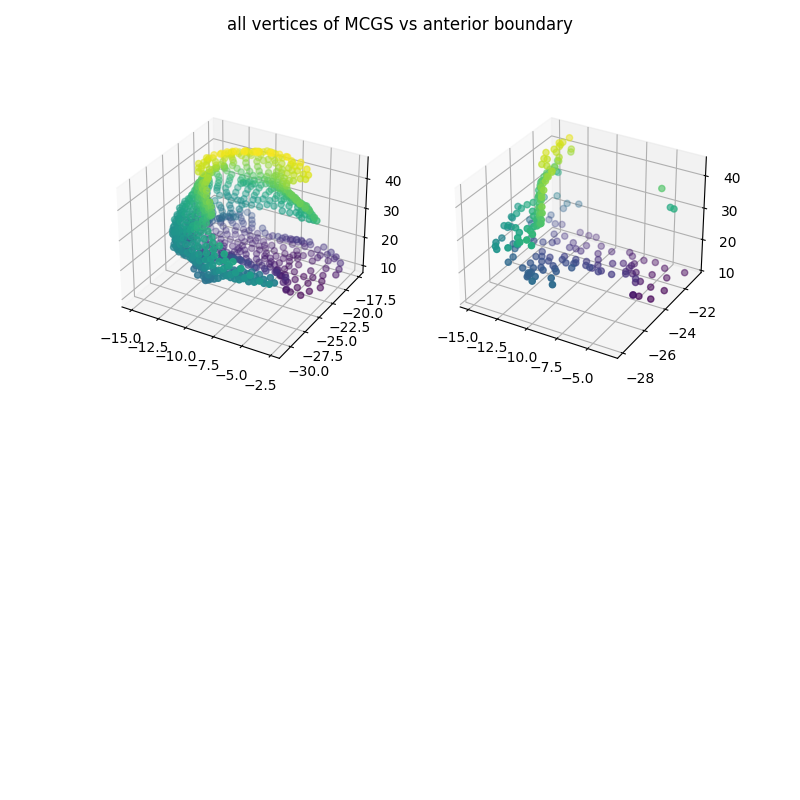

In [33]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax2.scatter3D(test_r_data_min_inferior, test_a_data_min_inferior, test_s_data_min_inferior, cmap='viridis', c=test_s_data_min_inferior, vmin=10, vmax=45)
ax2.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs anterior boundary')

## Pycortex

In [ ]:

# project_dir = Path('/Users/benparker/Desktop/cnl/CNL_scalpel/results/')
# subjects_dir = Path('/Users/benparker/Desktop/cnl/subjects/')
# subjects_dir_str = '/Users/benparker/Desktop/cnl/subjects/'

# ## read_annot returns [0] labels at each vertex, -1 for no id [1]: ctab [2]: label names 
# annot_verts, annot_ctab, annot_names = read_annot(subjects_dir / '100307/label/rh.aparc.a2009s.annot')


# # import test subject to pycortex db
# cortex.freesurfer.import_subj('100307', freesurfer_subject_dir=subjects_dir_str, whitematter_surf='white')


In [ ]:


## split FC map by boundary sulci

##### ID vertices within boundary by [0] from read annot

## Mesh traversal

In [59]:
subjects_dir = '/Users/benparker/Desktop/cnl/subjects'
labels = ['POS','MCGS']
sub = '100307'
hemi = 'lh'
outdir = '/Users/benparker/Desktop/cnl/CNL_scalpel/results'

#getDistMatrix(subjects_dir,labels,sub,hemi,outdir, fmri_prep=False)

highres_surface = f'{subjects_dir}/{sub}/surf/{hemi}.pial'
    
 
giidata = nb.freesurfer.read_geometry(highres_surface)
points, faces = giidata[0], giidata[1]

### Do not use nibabel to read_labels because only returns vertices, not coordinates
DONT_label_ind = nb.freesurfer.read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.POS.label')

label_faces = faces[label_ind]

label_ind, label_RAS = read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.POS.label')
label_points_POS = points[label_ind_POS]
label_faces_POS = faces[label_ind_POS]


In [58]:
label_ind

array([13243, 13244, 13251, ..., 35287, 35288, 35289])

In [52]:
label_RAS

array([[ 22.191, -49.065,   0.173],
       [ 21.966, -49.416,   0.577],
       [ 22.166, -49.152,  -0.27 ],
       ...,
       [ 15.147, -27.109, -14.139],
       [ 14.451, -26.8  , -14.015],
       [ 13.454, -26.752, -14.01 ]])

In [46]:


def get_label_faces(points, faces, label_ind):
    """ Takes a list of points in XYZ space and a list of faces composed of 3 points. 
    Identify which faces include the points at points[label_index]
    Return the faces that contain the points.

    INPUT:
    points: array of points in XYZ space
    faces: array of faces composed of 3 points
    label_ind: array of indices of points in the label

    OUTPUT:
    label_faces: array of faces that contain the points in the label
    """
    all_label_faces = []
    label_points = points[label_ind]

    for face in faces[:5]:
        for point_index in face:
            point_in_face = points[point_index]
            if check_if_in_list(face, label_ind):
                all_label_faces.append(list(face))

    return np.array(all_label_faces)

In [77]:
def get_faces_for_label(faces, label_ind):
    """
    Takes a list of faces and label indices
    Returns the faces that contain the indices

    INPUT:
    faces: array of faces composed of 3 points
    label_ind: array of indices of points in the label

    OUTPUT:
    label_faces: array of faces that contain the points in the label
    """
    all_label_faces = []
    for face in faces:
        for point_index in face:
            if point_index in label_ind:
                all_label_faces.append(list(face))
    return np.array(all_label_faces)

In [78]:
label_faces = get_faces_for_label(faces, label_ind)

In [79]:
label_faces

array([[12403, 13231, 13244],
       [12403, 13244, 12415],
       [13251, 13238, 12421],
       ...,
       [35288, 35289, 36230],
       [36231, 36230, 35289],
       [35288, 36230, 35294]], dtype=int32)

In [47]:
## TODO these two plots look like they're different, they shouldn't be

Meshplot seems to be rendering the whole brain well. But the label for now is not rendering properly. Thisd could be because 1) I'm selecting the wrong faces for the plot 2) an indexing difference between points and faces that I haven't found yet 3) a problem with meshplot

In [87]:
meshplot.plot(points, label_faces)
meshplot.plot(points, faces)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-30.50172…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-30.50172…

Same issue with Trimesh - an alternate plotting libary

In [94]:
import trimesh as tm

mesh = tm.Trimesh(vertices= points, faces = faces)

In [100]:
mesh.show()

In [99]:

label_mesh = tm.Trimesh(vertices= points, faces = label_faces)
label_mesh.show()